In [1]:
!pip install seaborn 
!pip install folium 
!pip install plotly
!pip install osmnx
!pip install ortools
!pip install nbformat
!pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 7.2 MB/s eta 0:00:00a 0:00:01
Using cached tenacity-9.0.0-py3-none-any.whl (28 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.1 MB/s eta 0:00:00a 0:00:01
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import folium 
import plotly.express as px 
import osmnx as ox 
import networkx as nx 
from ortools.constraint_solver import pywrapcp 
from ortools.constraint_solver import routing_enums_pb2
import nbformat

In [25]:
dtf=pd.read_csv('100.csv')
dtf

,Bus No,Stop Name,Arrival Time,Distance,Latitude,Longitude
0,100,Kendriya Terminal (Church Road),07:00 AM,0 km,28.617312,77.203904
1,100,Kendriya Terminal / Gurudwara Rakab Gunj,07:01 AM,0.42 km,28.619525,77.206037
2,100,Talkatora Road,07:02 AM,0.25 km,28.625359,77.194289
3,100,RML Hospital,07:04 AM,0.57 km,28.625709,77.200634
4,100,RML Hospital,07:05 AM,0.1 km,28.625709,77.200634
5,100,Gurudwara Bangla Sahib,07:09 AM,1.06 km,28.625865,77.208952
6,100,YMCA / Palika Kendra,07:10 AM,0.32 km,28.626360,77.212680


In [4]:
dtf=dtf.reset_index().rename(columns={"index":"ID", "Latitude":"X", "Longitude":"Y"})

print("total", len(dtf))
dtf.head(3)

total 34


,ID,Bus No,Stop Name,Arrival Time,Distance,X,Y
0,0,03STL,Indraprastha Depot,06:00 AM,0.0,28.620282,77.248509
1,1,03STL,IP Power Station / ITO Ring Road,06:02 AM,0.5,28.624490,77.247160
2,2,03STL,ITO Ring Road,06:04 AM,0.6,28.626474,77.246701


In [5]:
# Create empty lists to store start and finish points
start_points = []
finish_points = []
stop_points = []

# Copying data and initializing the 'color' column
data = dtf.copy()
data["color"] = ''

# Assigning colors and saving start/finish points
for bus_no, group in data.groupby('Bus No'):
    start_point = group.iloc[0][['X', 'Y']].tolist()
    finish_point = group.iloc[-1][['X', 'Y']].tolist()
    
    start_points.append(start_point)
    finish_points.append(finish_point)
    stop_point = group.iloc[1:-1][['X', 'Y']].values.tolist()
    
    data.loc[group.head(1).index, 'color'] = 'red'    # Starting points
    data.loc[group.tail(1).index, 'color'] = 'green'  # Finishing points

data.loc[data['color'] == '', 'color'] = 'black'

In [6]:
start = data[data["ID"]==0][["X","Y"]].values[0]
start

array([28.62028159, 77.24850874])

In [7]:
# visualize the points on a map
map = folium.Map(location=start_point, tiles="cartodbpositron", zoom_start=14)
# Plot each start point in red
for start_point in start_points:
    folium.Marker(
        location=start_point, 
        icon=folium.Icon(color="red"), fill=True, radius=7).add_to(map)

# Plot each finish point in green
for finish_point in finish_points:
    folium.Marker(
        location=finish_point, 
        icon=folium.Icon(color="green"), fill=True, radius=7).add_to(map)

# Plot remaining stops in black
data.apply(lambda row: 
    folium.Marker(
        location=[row["X"], row["Y"]],
        popup=row["Stop Name"],
        color=row["color"], fill=True, radius=5).add_to(map) if row["color"] == 'black' else None, axis=1)

map

/Users/danieldas/Documents/GitHub/Commute-Sense/commutesense/lib/python3.12/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


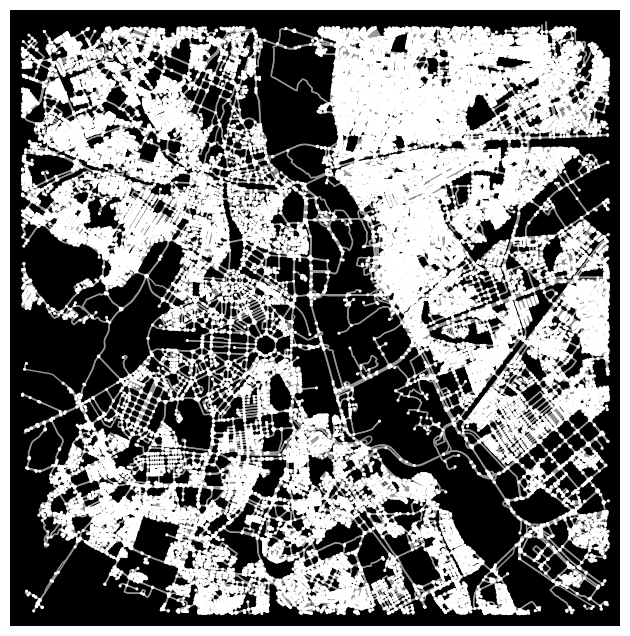

In [8]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5 , node_color="white", figsize=(16,8))

In [9]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["X", "Y"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf

/var/folders/_r/_c6_011j06jgkcs_mg23qs_80000gn/T/ipykernel_71241/2076254243.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["X", "Y"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
/var/folders/_r/_c6_011j06jgkcs_mg23qs_80000gn/T/ipykernel_71241/2076254243.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["X", "Y"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
/var/folders/_r/_c6_011j06jgkcs_mg23qs_80000gn/T/ipykernel_71241/2076254243.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, i

,ID,Bus No,Stop Name,Arrival Time,Distance,X,Y,node
0,0,03STL,Indraprastha Depot,06:00 AM,0.0,28.620282,77.248509,11959535738
1,1,03STL,IP Power Station / ITO Ring Road,06:02 AM,0.5,28.624490,77.247160,838633411
2,2,03STL,ITO Ring Road,06:04 AM,0.6,28.626474,77.246701,838633498
3,3,03STL,IG Stadium,06:06 AM,0.4,28.633718,77.246504,458631457
4,4,03STL,Gandhi Darshan,06:07 AM,0.4,28.636944,77.246646,838495877
5,5,03STL,Raj Ghat,06:09 AM,0.5,28.641494,77.246742,9880366639
6,6,03STL,Shakti Sthal,06:10 AM,0.6,28.645575,77.246755,938523162
7,7,03STL,Shanti Vana,06:12 AM,0.3,28.649174,77.245539,10277210962
8,8,03STL,Vijay Ghat,06:16 AM,1.0,28.657785,77.244779,938524083
9,9,03STL,Hanuman Mandir / Yamuna Bazar,06:20 AM,1.0,28.663014,77.236950,913282544


In [10]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix

,11959535738,838633411,838633498,458631457,838495877,9880366639,938523162,10277210962,938524083,913282544,...,6768532212,6622286266,9868017308,9867384066,918296744,913486408,920570499,918380850,920568983,918326453
11959535738,0.0,42.9,88.0,179.9,142.2,275.5,228.0,289.3,345.9,481.9,...,962.2,978.6,1026.4,1075.9,1089.2,1111.0,1215.0,1269.6,1427.4,1353.8
838633411,99.7,0.0,45.1,137.0,99.3,232.6,185.1,246.4,303.0,439.0,...,919.3,935.7,983.5,1033.0,1046.3,1068.1,1172.1,1226.7,1384.5,1310.9
838633498,54.6,97.5,0.0,234.5,196.8,330.1,282.6,343.9,400.5,536.5,...,1016.8,1033.2,1081.0,1130.5,1143.8,1165.6,1269.6,1324.2,1482.0,1408.4
458631457,101.7,144.6,94.1,0.0,162.1,295.4,247.9,309.2,365.8,501.8,...,982.1,998.5,1046.3,1095.8,1109.1,1130.9,1234.9,1289.5,1447.3,1373.7
838495877,139.4,182.3,131.8,37.7,0.0,133.3,85.8,147.1,203.7,339.7,...,820.0,836.4,884.2,933.7,947.0,968.8,1072.8,1127.4,1285.2,1211.6
9880366639,272.8,315.7,265.2,171.1,328.1,0.0,100.2,161.5,218.1,354.1,...,834.4,850.8,898.6,948.1,961.4,983.2,1087.2,1141.8,1263.6,1226.0
938523162,314.6,357.5,307.0,212.9,375.0,100.2,0.0,61.3,117.9,253.9,...,734.2,750.6,798.4,847.9,861.2,883.0,987.0,1041.6,1214.2,1125.8
10277210962,253.3,296.2,245.7,151.6,313.7,212.2,162.1,0.0,280.0,416.0,...,896.3,912.7,960.5,1010.0,1023.3,1045.1,1149.1,1203.7,1364.1,1287.9
938524083,497.1,540.0,489.5,395.4,534.0,341.3,305.9,264.9,0.0,139.8,...,620.1,636.5,684.3,733.8,747.1,768.9,872.9,927.5,1121.7,1011.7
913282544,431.4,474.3,423.8,329.7,491.8,352.9,317.5,206.6,270.4,0.0,...,588.9,605.3,653.1,702.6,715.9,737.7,841.7,896.3,1100.3,980.5


In [11]:
# Interpolate to replace np.nan with interpolated values
distance_matrix = distance_matrix.interpolate(method='linear', axis=0).interpolate(method='linear', axis=1)

# If you want to fill remaining np.nan values (e.g., on the edges), use this:
distance_matrix = distance_matrix.fillna(method='bfill', axis=0).fillna(method='ffill', axis=0)
distance_matrix = distance_matrix.fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)

# Display the interpolated distance matrix
distance_matrix

/var/folders/_r/_c6_011j06jgkcs_mg23qs_80000gn/T/ipykernel_71241/3326513575.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  distance_matrix = distance_matrix.fillna(method='bfill', axis=0).fillna(method='ffill', axis=0)
/var/folders/_r/_c6_011j06jgkcs_mg23qs_80000gn/T/ipykernel_71241/3326513575.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  distance_matrix = distance_matrix.fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)


,11959535738,838633411,838633498,458631457,838495877,9880366639,938523162,10277210962,938524083,913282544,...,6768532212,6622286266,9868017308,9867384066,918296744,913486408,920570499,918380850,920568983,918326453
11959535738,0.0,42.9,88.0,179.9,142.2,275.5,228.0,289.3,345.9,481.9,...,962.2,978.6,1026.4,1075.9,1089.2,1111.0,1215.0,1269.6,1427.4,1353.8
838633411,99.7,0.0,45.1,137.0,99.3,232.6,185.1,246.4,303.0,439.0,...,919.3,935.7,983.5,1033.0,1046.3,1068.1,1172.1,1226.7,1384.5,1310.9
838633498,54.6,97.5,0.0,234.5,196.8,330.1,282.6,343.9,400.5,536.5,...,1016.8,1033.2,1081.0,1130.5,1143.8,1165.6,1269.6,1324.2,1482.0,1408.4
458631457,101.7,144.6,94.1,0.0,162.1,295.4,247.9,309.2,365.8,501.8,...,982.1,998.5,1046.3,1095.8,1109.1,1130.9,1234.9,1289.5,1447.3,1373.7
838495877,139.4,182.3,131.8,37.7,0.0,133.3,85.8,147.1,203.7,339.7,...,820.0,836.4,884.2,933.7,947.0,968.8,1072.8,1127.4,1285.2,1211.6
9880366639,272.8,315.7,265.2,171.1,328.1,0.0,100.2,161.5,218.1,354.1,...,834.4,850.8,898.6,948.1,961.4,983.2,1087.2,1141.8,1263.6,1226.0
938523162,314.6,357.5,307.0,212.9,375.0,100.2,0.0,61.3,117.9,253.9,...,734.2,750.6,798.4,847.9,861.2,883.0,987.0,1041.6,1214.2,1125.8
10277210962,253.3,296.2,245.7,151.6,313.7,212.2,162.1,0.0,280.0,416.0,...,896.3,912.7,960.5,1010.0,1023.3,1045.1,1149.1,1203.7,1364.1,1287.9
938524083,497.1,540.0,489.5,395.4,534.0,341.3,305.9,264.9,0.0,139.8,...,620.1,636.5,684.3,733.8,747.1,768.9,872.9,927.5,1121.7,1011.7
913282544,431.4,474.3,423.8,329.7,491.8,352.9,317.5,206.6,270.4,0.0,...,588.9,605.3,653.1,702.6,715.9,737.7,841.7,896.3,1100.3,980.5


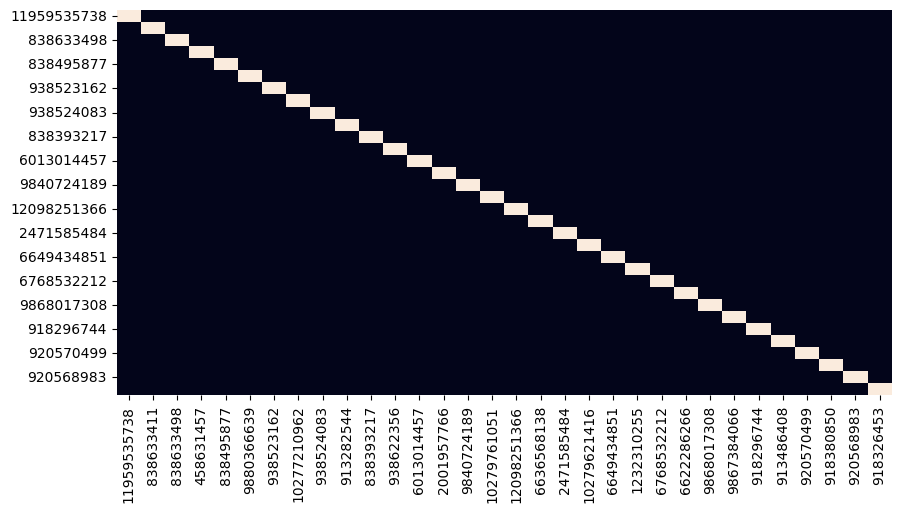

In [12]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x: 
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else 
          (0 if x!=0 else 1)) )
    
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=False, ax=ax)
plt.show()

In [13]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

,11959535738,838633411,838633498,458631457,838495877,9880366639,938523162,10277210962,938524083,913282544,...,6768532212,6622286266,9868017308,9867384066,918296744,913486408,920570499,918380850,920568983,918326453
11959535738,0,43,88,180,142,276,228,289,346,482,...,962,979,1026,1076,1089,1111,1215,1270,1427,1354
838633411,100,0,45,137,99,233,185,246,303,439,...,919,936,984,1033,1046,1068,1172,1227,1384,1311
838633498,55,98,0,234,197,330,283,344,400,536,...,1017,1033,1081,1131,1144,1166,1270,1324,1482,1408
458631457,102,145,94,0,162,295,248,309,366,502,...,982,998,1046,1096,1109,1131,1235,1290,1447,1374
838495877,139,182,132,38,0,133,86,147,204,340,...,820,836,884,934,947,969,1073,1127,1285,1212
9880366639,273,316,265,171,328,0,100,162,218,354,...,834,851,899,948,961,983,1087,1142,1264,1226
938523162,315,357,307,213,375,100,0,61,118,254,...,734,751,798,848,861,883,987,1042,1214,1126
10277210962,253,296,246,152,314,212,162,0,280,416,...,896,913,961,1010,1023,1045,1149,1204,1364,1288
938524083,497,540,490,395,534,341,306,265,0,140,...,620,636,684,734,747,769,873,927,1122,1012
913282544,431,474,424,330,492,353,318,207,270,0,...,589,605,653,703,716,738,842,896,1100,980


In [14]:
drivers = 1
lst_nodes= dtf["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 11959535738 total locations to visit 31 drivers 1


In [15]:
lst_nodes

[11959535738,
 838633411,
 838633498,
 458631457,
 838495877,
 9880366639,
 938523162,
 10277210962,
 938524083,
 913282544,
 838393217,
 938622356,
 6013014457,
 2001957766,
 9840724189,
 10279761051,
 12098251366,
 6636568138,
 2471585484,
 10279621416,
 6649434851,
 1232310255,
 6768532212,
 6622286266,
 9868017308,
 9867384066,
 918296744,
 913486408,
 920570499,
 918380850,
 920568983,
 918326453]

In [16]:
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model = pywrapcp.RoutingModel(manager)

In [17]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [19]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))
    
    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)
        
print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10454d280>>
Traceback (most recent call last):
  File "/Users/danieldas/Documents/GitHub/Commute-Sense/commutesense/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py", line 1543, in enumerate
    with _active_limbo_lock:
SystemError: <built-in method __enter__ of _thread.RLock object at 0x1010aa4c0> returned a result with an exception set
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10454d280>>
Traceback (most recent call last):
  File "/Users/danieldas/Documents/GitHub/Commute-Sen

route for driver:
[0, 4, 1, 2, 3, 6, 7, 5, 8, 10, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 30]
Total distance:3.22km
Nodes visited: 32


In [20]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[11959535738, 838495877, 838633411, 838633498, 458631457, 938523162, 10277210962, 9880366639, 938524083, 838393217, 913282544, 938622356, 6013014457, 2001957766, 9840724189, 10279761051, 12098251366, 6636568138, 2471585484, 10279621416, 1232310255, 6649434851, 6768532212, 6622286266, 9868017308, 9867384066, 918296744, 913486408, 920570499, 918380850, 918326453, 920568983]


In [21]:
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
    
map

/var/folders/_r/_c6_011j06jgkcs_mg23qs_80000gn/T/ipykernel_71241/1296747685.py:19: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
/var/folders/_r/_c6_011j06jgkcs_mg23qs_80000gn/T/ipykernel_71241/1296747685.py:19: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrati

In [22]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], [] 
        
        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])
            
        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))
        
    df=df.reset_index().rename(columns={"index":"id"})
    return df
            

In [23]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [24]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="Y", lat="X").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig
